<a href="https://colab.research.google.com/github/jrclavier/aurelius_ds_fin/blob/main/Aurelius_WorkingSheet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Step 0: To start ...

In [1]:
# Turn on multi-threading on your computer for faster calculation
%env OMP_NUM_THREADS = 4

env: OMP_NUM_THREADS=4


# Step 1 - Install and load the necessary packages and libraries

In [2]:

# Step 1: Load commonly used packages and libraries

import numpy as np # recall that "np" etc. -- are abbreviated names we gave to these packages for notational convenience
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report, confusion_matrix, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
#import warningsimport numpy as np
from scipy import stats
from pandas.api.types import is_numeric_dtype


import sys
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Step 2 - Load the Intermediate Pre-processed datasets

Output files will be loaded in the next few lines from local or mounted drive for speed. Same could be done from Git or any other source

in detail, sir outputs were produced customers, payments, orders to product, orders to reviews, sellers and geo data

In [3]:
#Load from local files
# files will be present in "/content".
path = "/content/"
!ls "/content/"


bad_lines.txt  output_customers_1.csv	    output_orders_reviews_1.csv       sample_data
drive	       output_orders_product_1.csv  output_seller_city_TOCLEAN_1.csv


In [72]:

#Start with GEO --> We know there is an issue with a field store values for later

#with open('bad_lines.txt', 'w') as fp:
#    sys.stderr = fp

geo_df = pd.read_csv("/content/drive/MyDrive/Output Tables/output_geo_data.csv",
                          error_bad_lines=False,  engine='python')

#We see a precision issue in the geo data that will be fixed in the next step.. Bad data will be skipped for now

<ipython-input-72-08e1971a85cb>:6: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  geo_df = pd.read_csv("/content/drive/MyDrive/Output Tables/output_geo_data.csv",
Skipping line 73290: Expected 5 fields in line 73290, saw 7
Skipping line 195493: Expected 5 fields in line 195493, saw 7


In [162]:
#Next Customers and Sellers
path = "/content/"

cust_df = pd.read_csv(path+"output_customers_1.csv", error_bad_lines=False,  engine='python')

#REMEMBER: there is a mistake in the dtypes of the city
seller_df = pd.read_csv(path+"output_seller_city_TOCLEAN_1.csv", error_bad_lines=False,  engine='python')

orders_review_df = pd.read_csv(path+"output_orders_reviews_1.csv", error_bad_lines=False,  engine='python')

orders_product_df = pd.read_csv(path+"output_orders_product_1.csv", error_bad_lines=False,  engine='python')

payments_df = pd.read_csv("/content/drive/MyDrive/Output Tables/output_order_payments.csv",
                          error_bad_lines=False,  engine='python')

<ipython-input-162-47394216f2a6>:4: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  cust_df = pd.read_csv(path+"output_customers_1.csv", error_bad_lines=False,  engine='python')
<ipython-input-162-47394216f2a6>:7: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  seller_df = pd.read_csv(path+"output_seller_city_TOCLEAN_1.csv", error_bad_lines=False,  engine='python')
<ipython-input-162-47394216f2a6>:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  orders_review_df = pd.read_csv(path+"output_orders_reviews_1.csv", error_bad_lines=False,  engine='python')
<ipython-input-162-47394216f2a6>:11: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in

In [7]:
#INSPECT DATA SETS PRIOR TO CLEAN UP
cust_df.dtypes

customer_id                 object
NOT_customer_unique_id      object
customer_zip_code_prefix     int64
customer_city               object
customer_state              object
Cust_Unique_ID              object
dtype: object

In [19]:
geo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720152 entries, 0 to 720151
Data columns (total 5 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   geolocation_zip_code_prefix  720152 non-null  int64  
 1   geolocation_lat              720152 non-null  float64
 2   geolocation_lng              720152 non-null  float64
 3   geolocation_city             720152 non-null  object 
 4   geolocation_state            720152 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 27.5+ MB


In [18]:
seller_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB


In [17]:
orders_product_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102425 entries, 0 to 102424
Data columns (total 18 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   product_id                     102425 non-null  object 
 1   Sum_order_item_id              102425 non-null  int64  
 2   order_id                       102425 non-null  object 
 3   seller_id                      102425 non-null  object 
 4   shipping_limit_date            102425 non-null  object 
 5   Sum_price                      102425 non-null  float64
 6   Sum_freight_value              102425 non-null  float64
 7   Right_product_id               102425 non-null  object 
 8   product_category_name          100965 non-null  object 
 9   product_name_lenght            100965 non-null  float64
 10  product_description_lenght     100965 non-null  float64
 11  product_photos_qty             100965 non-null  float64
 12  product_weight_g              

In [16]:
orders_review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_id                       99441 non-null  object 
 1   customer_id                    99441 non-null  object 
 2   order_status                   99441 non-null  object 
 3   order_purchase_timestamp       99441 non-null  object 
 4   order_approved_at              99281 non-null  object 
 5   order_delivered_carrier_date   97658 non-null  object 
 6   order_delivered_customer_date  96476 non-null  object 
 7   order_estimated_delivery_date  99441 non-null  object 
 8   review_id                      98673 non-null  object 
 9   review_score                   98673 non-null  float64
 10  review_comment_title           11551 non-null  object 
 11  review_comment_message         40795 non-null  object 
 12  review_creation_date           98672 non-null 

In [165]:
payments_df.dtypes

order_id                     object
Sum_payment_installments      int64
Sum_payment_value             int64
Concat_payment_type          object
Concat_payment_sequential    object
dtype: object

In [166]:
geo_df.describe(include='all').round(1)

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
count,720152.0,720152.0,720152.0,720152,720152
unique,NaN,NaN,NaN,7921,27
top,NaN,NaN,NaN,sao paulo,SP
freq,NaN,NaN,NaN,79923,274572
mean,38611.2,-21.0,-46.5,NaN,NaN
std,30576.6,5.9,4.4,NaN,NaN
min,1001.0,-36.6,-101.5,NaN,NaN
25%,13043.0,-23.6,-48.9,NaN,NaN
50%,29345.0,-22.9,-46.6,NaN,NaN
75%,66053.0,-19.9,-43.8,NaN,NaN


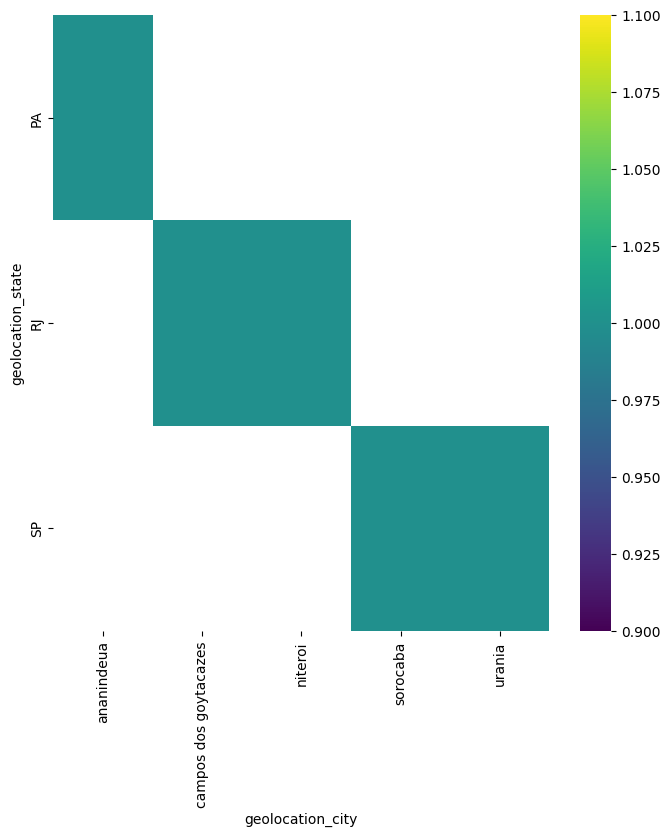

In [22]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['geolocation_state'].value_counts()
    for x_label, grp in _df_10.groupby('geolocation_city')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('geolocation_city')
_ = plt.ylabel('geolocation_state')

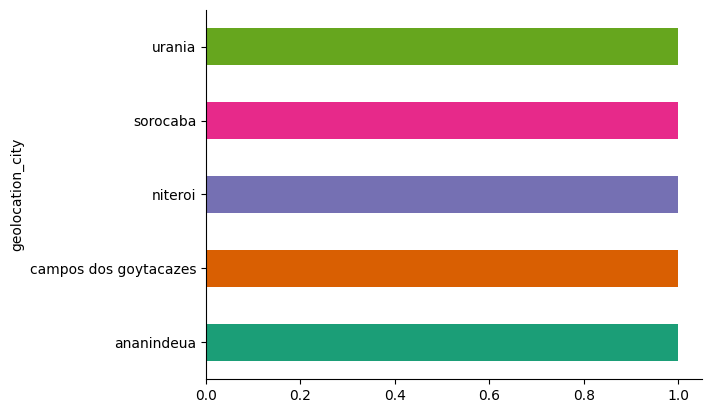

In [21]:
from matplotlib import pyplot as plt
import seaborn as sns
_df_3.groupby('geolocation_city').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)


#Step 3 - "Cleaning" and analyzing the data

Let's start one by one analyzing and inspecting values. Based on our previous inspection in Alteryx, GEO seems to be the most polluted table, followed by seller, product, customers, reviews and lastly payments..

If we follow this order:

### 3.1 GEO Data: Nulls Decimals, Accents driving duplicates

In [104]:
#GEO Analysis, lets fix floats to 3 decimals, and try to see duplicates across columns so we keep unique keys

geo_df.info()

#reconfigure zip to be merged later
#geo_df['geolocation_zip_code_prefix'] = geo_df['geolocation_zip_code_prefix'].astype('datetime64', errors='ignore')

geo_df = geo_df.round(3)

geo_df_s= geo_df.drop_duplicates(keep=False)

geo_df_s.head()

geo_df_s.isnull().mean() * 100

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720152 entries, 0 to 720151
Data columns (total 5 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   geolocation_zip_code_prefix  720152 non-null  int64  
 1   geolocation_lat              720152 non-null  float64
 2   geolocation_lng              720152 non-null  float64
 3   geolocation_city             720152 non-null  object 
 4   geolocation_state            720152 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 27.5+ MB


geolocation_zip_code_prefix    0.0
geolocation_lat                0.0
geolocation_lng                0.0
geolocation_city               0.0
geolocation_state              0.0
dtype: float64

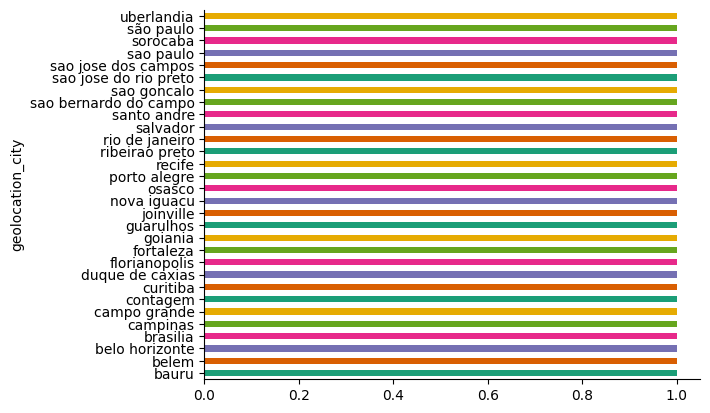

In [76]:
geo_df_zips = geo_df_s.groupby(['geolocation_state','geolocation_city'], as_index=False)\
.agg(value = ('geolocation_zip_code_prefix', 'count'))


geo_df_zips.nlargest(30, "value").groupby('geolocation_city').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [191]:
#Accents are driving a lot of the duplicates... lets normalize

geo_df_s['geolocation_city'] = geo_df_s['geolocation_city'].str.normalize('NFKD').str.encode('ascii',errors='ignore').str.decode('utf-8')

geo_df_acc= geo_df_s.drop_duplicates(keep=False)

#inspect new dataset
geo_df_zips = geo_df_acc.groupby(['geolocation_state','geolocation_city'], as_index=False)\
.agg(value = ('geolocation_zip_code_prefix', 'count'))

geo_df_zips

geo_df_s.dtypes


<ipython-input-191-f5acf62710b1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geo_df_s['geolocation_city'] = geo_df_s['geolocation_city'].str.normalize('NFKD').str.encode('ascii',errors='ignore').str.decode('utf-8')


geolocation_zip_code_prefix      int64
geolocation_lat                float64
geolocation_lng                float64
geolocation_city                object
geolocation_state               object
dtype: object

In [160]:
geo_df_s.describe(include = 'all').round(1)

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
count,419115.0,419115.0,419115.0,419115,419115
unique,NaN,NaN,NaN,7897,27
top,NaN,NaN,NaN,sao paulo,SP
freq,NaN,NaN,NaN,28050,142749
mean,43418.7,-20.5,-46.8,NaN,NaN
std,31149.9,6.5,4.8,NaN,NaN
min,1001.0,-36.6,-101.5,NaN,NaN
25%,14180.0,-23.6,-49.3,NaN,NaN
50%,35970.0,-22.7,-46.8,NaN,NaN
75%,75705.5,-19.2,-43.9,NaN,NaN


#### Much Better Now

In [59]:
geo_df_acc.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
2,18046,-23.526,-47.476,sorocaba,SP
5,40484,-12.910,-38.474,salvador,BA
6,83823,-25.656,-49.306,fazenda rio grande,PR
10,6550,-23.402,-47.007,pirapora do bom jesus,SP
12,7022,-23.461,-46.408,guarulhos,SP


from matplotlib import pyplot as plt
_df_90['geolocation_zip_code_prefix'].plot(kind='hist', bins=20, title='geolocation_zip_code_prefix')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_91['geolocation_lat'].plot(kind='hist', bins=20, title='geolocation_lat')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_92['geolocation_lng'].plot(kind='hist', bins=20, title='geolocation_lng')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_93.groupby('geolocation_city').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_94.groupby('geolocation_state').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_95.plot(kind='scatter', x='geolocation_zip_code_prefix', y='geolocation_lat', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_96.plot(kind='scatter', x='geolocation_lat', y='geolocation_lng', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_97['geolocation_zip_code_prefix'].plot(kind='line', figsize=(8, 4), title='geolocation_zip_code_prefix')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_98['geolocation_lat'].plot(kind='line', figsize=(8, 4), title='geolocation_lat')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_99['geolocation_lng'].plot(kind='line', figsize=(8, 4), title='geolocation_lng')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['geolocation_state'].value_counts()
    for x_label, grp in _df_100.groupby('geolocation_city')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('geolocation_city')
_ = plt.ylabel('geolocation_state')

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_101['geolocation_city'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_101, x='geolocation_zip_code_prefix', y='geolocation_city', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_102['geolocation_state'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_102, x='geolocation_zip_code_prefix', y='geolocation_state', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_103['geolocation_city'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_103, x='geolocation_lat', y='geolocation_city', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_104['geolocation_state'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_104, x='geolocation_lat', y='geolocation_state', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

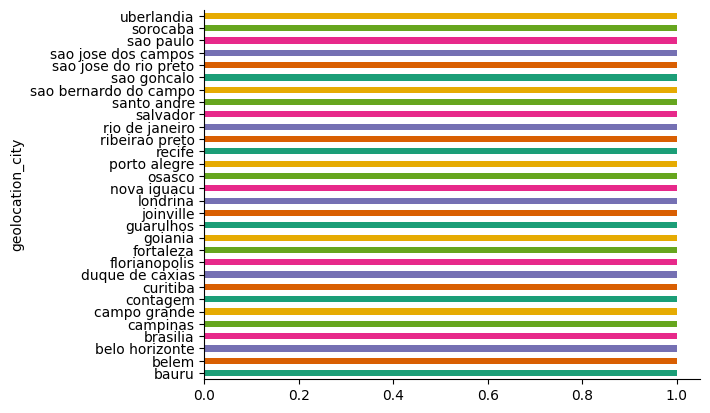

In [68]:
geo_df_zips.nlargest(30, "value").groupby('geolocation_city').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [208]:
# Define types of columns to start driving naming consistency

geo_df_acc.dtypes

geo_df_acc= geo_df_acc.rename(columns={'geolocation_zip_code_prefix': 'zip_code_p','geolocation_city':'city',
                                     'geolocation_state':'state'  })

geo_df_acc['zip_code_p'] = geo_df_acc['zip_code_p'].astype(str)
geo_df_acc.dtypes


zip_code_p          object
geolocation_lat    float64
geolocation_lng    float64
city                object
state               object
dtype: object

### 3.2 Seller Data: Numerical value in city, nulls and Accents test


In [105]:
# Same with Seller data

seller_df.info()
seller_df.head()

# Remove first city is bad but keep to see if the city can be found out later


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB


,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,ceb7b4fb9401cd378de7886317ad1b47,22790,04482255,RJ
1,c8143b3069f6746a77421b5ce30a450c,75345,abadia de goias,GO
2,2f4b9d112bfa44a214bc6cef085d17c8,29600,afonso claudio,ES
3,3a52d63a8f9daf5a28f3626d7eb9bd28,71900,aguas claras df,SP
4,717b78b0950b51ed00b1471d858b0edc,18220,alambari,SP


In [138]:
seller_df_zips = seller_df.groupby(['seller_state','seller_city'], as_index=False)\
.agg(value = ('seller_id', 'count'))

seller_df_zips

,seller_state,seller_city,value
0,AC,rio branco,1
1,AM,manaus,1
2,BA,arraial d'ajuda (porto seguro),1
3,BA,bahia,1
4,BA,barro alto,1
...,...,...,...
629,SP,vicente de carvalho,1
630,SP,vila velha,1
631,SP,volta redonda,1
632,SP,votorantim,4


In [110]:
seller_df.isnull().mean() * 100

seller_id                 0.0
seller_zip_code_prefix    0.0
seller_city               0.0
seller_state              0.0
dtype: float64

In [158]:
# Remove accents just in case

seller_df['seller_city'] = seller_df['seller_city'].str.normalize('NFKD').str.encode('ascii',errors='ignore').str.decode('utf-8')
seller_df_acc= seller_df.drop_duplicates(keep=False)

#inspect new dataset
seller_df_acc.describe(include='all').round(1)

,seller_id,seller_zip_code_prefix,seller_city,seller_state
count,3095,3095.0,3095,3095
unique,3095,NaN,609,23
top,ceb7b4fb9401cd378de7886317ad1b47,NaN,sao paulo,SP
freq,1,NaN,695,1849
mean,NaN,32291.1,NaN,NaN
std,NaN,32713.5,NaN,NaN
min,NaN,1001.0,NaN,NaN
25%,NaN,7093.5,NaN,NaN
50%,NaN,14940.0,NaN,NaN
75%,NaN,64552.5,NaN,NaN


In [207]:
# Define types of columns to start driving naming consistency and data types

seller_df_acc.dtypes

seller_df_acc= seller_df_acc.rename(columns={'seller_zip_code_prefix': 'zip_code','seller_city':'city',
                                     'seller_state':'state'  })

seller_df_acc['zip_code_p'] = seller_df_acc['zip_code'].astype(str)

seller_df_acc.head()


,seller_id,zip_code,city,state,zip_code_p
0,ceb7b4fb9401cd378de7886317ad1b47,22790,04482255,RJ,22790
1,c8143b3069f6746a77421b5ce30a450c,75345,abadia de goias,GO,75345
2,2f4b9d112bfa44a214bc6cef085d17c8,29600,afonso claudio,ES,29600
3,3a52d63a8f9daf5a28f3626d7eb9bd28,71900,aguas claras df,SP,71900
4,717b78b0950b51ed00b1471d858b0edc,18220,alambari,SP,18220


from matplotlib import pyplot as plt
_df_162['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_163.groupby('seller_id').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_164.groupby('zip_code').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_165.groupby('city').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_166.groupby('state').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_167.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('seller_id')):
  _plot_series(series, series_name, i)
  fig.legend(title='seller_id', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_168.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('zip_code')):
  _plot_series(series, series_name, i)
  fig.legend(title='zip_code', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_169.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('city')):
  _plot_series(series, series_name, i)
  fig.legend(title='city', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_170.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('state')):
  _plot_series(series, series_name, i)
  fig.legend(title='state', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_171['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['zip_code'].value_counts()
    for x_label, grp in _df_172.groupby('seller_id')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('seller_id')
_ = plt.ylabel('zip_code')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['city'].value_counts()
    for x_label, grp in _df_173.groupby('zip_code')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('zip_code')
_ = plt.ylabel('city')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['state'].value_counts()
    for x_label, grp in _df_174.groupby('city')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('city')
_ = plt.ylabel('state')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['zip_code_p'].value_counts()
    for x_label, grp in _df_175.groupby('state')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('state')
_ = plt.ylabel('zip_code_p')

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_176['seller_id'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_176, x='index', y='seller_id', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_177['zip_code'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_177, x='index', y='zip_code', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_178['city'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_178, x='index', y='city', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_179['state'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_179, x='index', y='state', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

### 3.3 Product-Order Data: Post an incomplete translation and a controlled join with the Orders Items, Check for Accents, nulls and Dtypes

All Items from the list where joined to a product ID but not all product IDs were, there are null values in the product specs...

In [101]:
orders_product_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102425 entries, 0 to 102424
Data columns (total 18 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   product_id                     102425 non-null  object 
 1   Sum_order_item_id              102425 non-null  int64  
 2   order_id                       102425 non-null  object 
 3   seller_id                      102425 non-null  object 
 4   shipping_limit_date            102425 non-null  object 
 5   Sum_price                      102425 non-null  float64
 6   Sum_freight_value              102425 non-null  float64
 7   Right_product_id               102425 non-null  object 
 8   product_category_name          100965 non-null  object 
 9   product_name_lenght            100965 non-null  float64
 10  product_description_lenght     100965 non-null  float64
 11  product_photos_qty             100965 non-null  float64
 12  product_weight_g              

In [156]:
orders_product_df.describe(include='all').round(2)

,product_id,Sum_order_item_id,order_id,seller_id,shipping_limit_date,Sum_price,Sum_freight_value,Right_product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_error,product_category_name_english
count,102425,102425.00,102425,102425,102425,102425.00,102425.00,102425,100965,100965.00,100965.00,100965.00,102409.00,102409.00,102409.00,102409.00,102425,100943
unique,32951,NaN,98666,3095,555,NaN,NaN,32951,73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,71
top,99a4788cb24856965c36a24e339b6058,NaN,ca3625898fbd48669d50701aba51cd5f,6560211a19b47992c3666cc44a7e94c0,2017-11-30,NaN,NaN,99a4788cb24856965c36a24e339b6058,cama_mesa_banho,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OK,bed_bath_table
freq,467,NaN,8,1982,1477,NaN,NaN,467,10160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100943,10160
mean,NaN,1.32,NaN,NaN,NaN,132.70,21.99,NaN,NaN,48.87,787.26,2.24,2090.92,30.09,16.41,23.04,NaN,NaN
std,NaN,2.00,NaN,NaN,NaN,205.31,20.46,NaN,NaN,10.00,650.59,1.74,3750.96,16.10,13.31,11.75,NaN,NaN
min,NaN,1.00,NaN,NaN,NaN,0.85,0.00,NaN,NaN,5.00,4.00,1.00,0.00,7.00,2.00,6.00,NaN,NaN
25%,NaN,1.00,NaN,NaN,NaN,44.90,13.52,NaN,NaN,43.00,348.00,1.00,300.00,18.00,8.00,15.00,NaN,NaN
50%,NaN,1.00,NaN,NaN,NaN,81.00,16.85,NaN,NaN,52.00,603.00,2.00,700.00,25.00,13.00,20.00,NaN,NaN
75%,NaN,1.00,NaN,NaN,NaN,147.90,23.26,NaN,NaN,57.00,987.00,3.00,1800.00,38.00,20.00,30.00,NaN,NaN


In [114]:
orders_product_df.isnull().mean() * 100

product_id                       0.000000
Sum_order_item_id                0.000000
order_id                         0.000000
seller_id                        0.000000
shipping_limit_date              0.000000
Sum_price                        0.000000
Sum_freight_value                0.000000
Right_product_id                 0.000000
product_category_name            1.425433
product_name_lenght              1.425433
product_description_lenght       1.425433
product_photos_qty               1.425433
product_weight_g                 0.015621
product_length_cm                0.015621
product_height_cm                0.015621
product_width_cm                 0.015621
product_error                    0.000000
product_category_name_english    1.446912
dtype: float64

In [151]:
# Take a look into product family with some stats

orders_product_df_cat = orders_product_df.groupby(['product_category_name_english'], as_index=False)\
.agg(avg_price = ('Sum_price', 'mean'),avg_freight = ('Sum_freight_value', 'mean'), avg_weight = ('product_weight_g','mean'),
     count_seller = ('seller_id','count'),count_order = ('order_id','count'))


orders_product_df_cat.round(1).sort_values(by=['count_seller'], ascending=False)

,product_category_name_english,avg_price,avg_freight,avg_weight,count_seller,count_order
7,bed_bath_table,102.1,20.1,2157.7,10160,10160
43,health_beauty,139.5,20.2,1069.4,9022,9022
65,sports_leisure,125.7,21.5,1781.4,7858,7858
15,computers_accessories,132.4,21.4,911.8,6887,6887
39,furniture_decor,107.6,25.5,2773.1,6781,6781
...,...,...,...,...,...,...
3,arts_and_craftmanship,75.6,15.4,1369.9,24,24
52,la_cuisine,158.1,25.7,3780.8,13,13
11,cds_dvds_musicals,60.8,18.7,550.0,12,12
29,fashion_childrens_clothes,71.2,11.9,265.0,8,8


from matplotlib import pyplot as plt
_df_150['avg_price'].plot(kind='hist', bins=20, title='avg_price')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_151['avg_freight'].plot(kind='hist', bins=20, title='avg_freight')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_152['avg_weight'].plot(kind='hist', bins=20, title='avg_weight')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_153['count_seller'].plot(kind='hist', bins=20, title='count_seller')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_154.plot(kind='scatter', x='avg_price', y='avg_freight', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_155.plot(kind='scatter', x='avg_freight', y='avg_weight', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_156.plot(kind='scatter', x='avg_weight', y='count_seller', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_157.plot(kind='scatter', x='count_seller', y='count_order', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_158['avg_price'].plot(kind='line', figsize=(8, 4), title='avg_price')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_159['avg_freight'].plot(kind='line', figsize=(8, 4), title='avg_freight')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_160['avg_weight'].plot(kind='line', figsize=(8, 4), title='avg_weight')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_161['count_seller'].plot(kind='line', figsize=(8, 4), title='count_seller')
plt.gca().spines[['top', 'right']].set_visible(False)

In [155]:
orders_product_df.describe(include='all').round(1)

,product_id,Sum_order_item_id,order_id,seller_id,shipping_limit_date,Sum_price,Sum_freight_value,Right_product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_error,product_category_name_english
count,102425,102425.0,102425,102425,102425,102425.0,102425.0,102425,100965,100965.0,100965.0,100965.0,102409.0,102409.0,102409.0,102409.0,102425,100943
unique,32951,NaN,98666,3095,555,NaN,NaN,32951,73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,71
top,99a4788cb24856965c36a24e339b6058,NaN,ca3625898fbd48669d50701aba51cd5f,6560211a19b47992c3666cc44a7e94c0,2017-11-30,NaN,NaN,99a4788cb24856965c36a24e339b6058,cama_mesa_banho,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OK,bed_bath_table
freq,467,NaN,8,1982,1477,NaN,NaN,467,10160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100943,10160
mean,NaN,1.3,NaN,NaN,NaN,132.7,22.0,NaN,NaN,48.9,787.3,2.2,2090.9,30.1,16.4,23.0,NaN,NaN
std,NaN,2.0,NaN,NaN,NaN,205.3,20.5,NaN,NaN,10.0,650.6,1.7,3751.0,16.1,13.3,11.7,NaN,NaN
min,NaN,1.0,NaN,NaN,NaN,0.8,0.0,NaN,NaN,5.0,4.0,1.0,0.0,7.0,2.0,6.0,NaN,NaN
25%,NaN,1.0,NaN,NaN,NaN,44.9,13.5,NaN,NaN,43.0,348.0,1.0,300.0,18.0,8.0,15.0,NaN,NaN
50%,NaN,1.0,NaN,NaN,NaN,81.0,16.8,NaN,NaN,52.0,603.0,2.0,700.0,25.0,13.0,20.0,NaN,NaN
75%,NaN,1.0,NaN,NaN,NaN,147.9,23.3,NaN,NaN,57.0,987.0,3.0,1800.0,38.0,20.0,30.0,NaN,NaN


### 3.4 Reviews-Order Data: Not all reviews had a corresponding product, not all products a review, This transactional table is key to understand the flow from sellers to buyers

flag review contains whether the order has been reviewed

null values in approval, carrier, delivery and on the reviews

null values in those dates could indicate an operational issue. Interesting to tie to a seller and a given geography

In [113]:
orders_review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_id                       99441 non-null  object 
 1   customer_id                    99441 non-null  object 
 2   order_status                   99441 non-null  object 
 3   order_purchase_timestamp       99441 non-null  object 
 4   order_approved_at              99281 non-null  object 
 5   order_delivered_carrier_date   97658 non-null  object 
 6   order_delivered_customer_date  96476 non-null  object 
 7   order_estimated_delivery_date  99441 non-null  object 
 8   review_id                      98673 non-null  object 
 9   review_score                   98673 non-null  float64
 10  review_comment_title           11551 non-null  object 
 11  review_comment_message         40795 non-null  object 
 12  review_creation_date           98672 non-null 

In [115]:
orders_review_df.isnull().mean() * 100

#null values in approval, carrier, delivery and on the reviews
#null values in those dates could indicate an operational issue. Interesting to tie to a seller and a given geography

order_id                          0.000000
customer_id                       0.000000
order_status                      0.000000
order_purchase_timestamp          0.000000
order_approved_at                 0.160899
order_delivered_carrier_date      1.793023
order_delivered_customer_date     2.981668
order_estimated_delivery_date     0.000000
review_id                         0.772317
review_score                      0.772317
review_comment_title             88.384067
review_comment_message           58.975674
review_creation_date              0.773323
review_answer_timestamp           0.773323
review                            0.000000
dtype: float64

In [131]:
#Lets fillna before this to avoid issues

orders_review_df.fillna(0)

orders_review_df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,review
0,a316eee6dacbc0393c28dff3568a67ee,957f3479d00c3d8aaa4ccb50b22e5ac3,delivered,2018-05-17 14:20:39,2018-05-18 01:35:19,2018-05-18 14:57:00,2018-06-13 23:06:27,2018-06-06,7e211924b558886ca5625fa3f1e41536,1.0,odiei,infelizmente não fui feliz ao realizar essa co...,2018-06-09,2018-06-11 12:55:47,True
1,0653cf037de0812e8ba775b4a0ea9c2f,bf140fe2e3a26db29d95589b4e03b3ac,delivered,2018-01-11 16:30:57,2018-01-11 16:48:40,2018-01-12 21:13:38,2018-01-23 00:41:47,2018-02-07,7149b0b3f5eb5c13e361336974e8febc,1.0,NaN,NaN,2018-01-23,2018-01-24 10:50:31,True
2,12c49270845b0006a7036adda4045c74,9cfce2cdb27217970f887a8c3703116a,delivered,2018-02-21 13:32:45,2018-02-21 14:31:38,2018-02-23 20:23:04,2018-03-16 16:26:23,2018-03-14,06fa2406d29a5719b37315e21bffafeb,2.0,NaN,prazo excedido em muito.,2018-03-16,2018-03-16 11:54:57,True
3,e23ca832ba25d2d20b0ebacdfe401989,320820724a43fe701ae97500b3760a81,shipped,2018-01-24 14:17:10,2018-01-24 15:16:07,2018-01-25 20:15:08,NaT,2018-02-23,1b30acf4a3bc38694ede93b1c8a24221,1.0,NaN,meus caros ainda estou esperando a entrega do ...,2018-02-25,2018-02-26 14:42:10,True
4,47c1a8c65d33d1a87433294bea40a81b,650a53e13d36c61649a28f7547cd5cf3,delivered,2017-05-28 17:05:11,2017-05-28 17:15:10,2017-05-30 17:08:05,2017-06-01 14:11:01,2017-06-19,730f5a89394eae8affa3717ff4e78b11,5.0,NaN,NaN,2017-06-02,2017-06-02 23:44:01,True


In [236]:
# It might be interesting to transform dates and the review into a classifier to be used later


orders_review_df['order_purchase_timestamp'] = orders_review_df['order_purchase_timestamp'].astype('datetime64')
orders_review_df['order_approved_at'] = orders_review_df['order_approved_at'].astype('datetime64')
orders_review_df['order_delivered_carrier_date'] = orders_review_df['order_delivered_carrier_date'].astype('datetime64')
orders_review_df['order_delivered_customer_date'] = orders_review_df['order_delivered_customer_date'].astype('datetime64')
orders_review_df['order_estimated_delivery_date'] = orders_review_df['order_estimated_delivery_date'].astype('datetime64')


orders_review_df['review_creation_date'] = orders_review_df['review_creation_date'].astype('datetime64')
orders_review_df['review_answer_timestamp'] = orders_review_df['review_answer_timestamp'].astype('datetime64')

orders_review_df['review_score'] = orders_review_df['review_score'].astype(str)

orders_review_df.dtypes

orders_review_df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,review
0,a316eee6dacbc0393c28dff3568a67ee,957f3479d00c3d8aaa4ccb50b22e5ac3,delivered,2018-05-17 14:20:39,2018-05-18 01:35:19,2018-05-18 14:57:00,2018-06-13 23:06:27,2018-06-06,7e211924b558886ca5625fa3f1e41536,1.0,odiei,infelizmente não fui feliz ao realizar essa co...,2018-06-09,2018-06-11 12:55:47,True
1,0653cf037de0812e8ba775b4a0ea9c2f,bf140fe2e3a26db29d95589b4e03b3ac,delivered,2018-01-11 16:30:57,2018-01-11 16:48:40,2018-01-12 21:13:38,2018-01-23 00:41:47,2018-02-07,7149b0b3f5eb5c13e361336974e8febc,1.0,NaN,NaN,2018-01-23,2018-01-24 10:50:31,True
2,12c49270845b0006a7036adda4045c74,9cfce2cdb27217970f887a8c3703116a,delivered,2018-02-21 13:32:45,2018-02-21 14:31:38,2018-02-23 20:23:04,2018-03-16 16:26:23,2018-03-14,06fa2406d29a5719b37315e21bffafeb,2.0,NaN,prazo excedido em muito.,2018-03-16,2018-03-16 11:54:57,True
3,e23ca832ba25d2d20b0ebacdfe401989,320820724a43fe701ae97500b3760a81,shipped,2018-01-24 14:17:10,2018-01-24 15:16:07,2018-01-25 20:15:08,NaT,2018-02-23,1b30acf4a3bc38694ede93b1c8a24221,1.0,NaN,meus caros ainda estou esperando a entrega do ...,2018-02-25,2018-02-26 14:42:10,True
4,47c1a8c65d33d1a87433294bea40a81b,650a53e13d36c61649a28f7547cd5cf3,delivered,2017-05-28 17:05:11,2017-05-28 17:15:10,2017-05-30 17:08:05,2017-06-01 14:11:01,2017-06-19,730f5a89394eae8affa3717ff4e78b11,5.0,NaN,NaN,2017-06-02,2017-06-02 23:44:01,True


In [237]:
orders_review_df.describe(include="all")

orders_review_df.dtypes

<ipython-input-237-5a7b87a42dce>:1: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.

<ipython-input-237-5a7b87a42dce>:1: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.

<ipython-input-237-5a7b87a42dce>:1: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.

<ipython-input-237-5a7b87a42dce>:1: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and wi

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
review_id                                object
review_score                             object
review_comment_title                     object
review_comment_message                   object
review_creation_date             datetime64[ns]
review_answer_timestamp          datetime64[ns]
review                                     bool
dtype: object

### 3.5 Customer Data: Accents function and Dtypes + check if Not Cust Unique can be used elsewhere

In [92]:
# Same with Seller data

cust_df.info()
cust_df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96096 entries, 0 to 96095
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               96096 non-null  object
 1   NOT_customer_unique_id    96096 non-null  object
 2   customer_zip_code_prefix  96096 non-null  int64 
 3   customer_city             96096 non-null  object
 4   customer_state            96096 non-null  object
 5   Cust_Unique_ID            96096 non-null  object
dtypes: int64(1), object(5)
memory usage: 4.4+ MB


,customer_id,NOT_customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,Cust_Unique_ID
0,3a6e7307506713d97cd29c960e5f5a61,763f8a08704b708c43b73507d13ab0ce,5143,sao paulo,SP,Unique
1,fac3296ec4f116faccfa6a6d7e18b42f,4ed128a71a16c4cebc15ed8537d37ed4,15150,monte aprazivel,SP,Unique
2,b49b8fc199c7b5e7f87655ef2d542874,0874cecfab8aecc80ae065af07035e5b,20511,rio de janeiro,RJ,Unique
3,fd72e5a673c5b0cb41b16a6415e622ce,e91806f87029b7c1a2c758317d93b8ba,22723,rio de janeiro,RJ,Unique
4,1373bf3289262687cf4e388a8318d8d5,5d9a935069dbcca38415cb23b8cc4ef4,4195,sao paulo,SP,Unique


from matplotlib import pyplot as plt
_df_125['customer_zip_code_prefix'].plot(kind='hist', bins=20, title='customer_zip_code_prefix')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_126.groupby('customer_id').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_127.groupby('NOT_customer_unique_id').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_128.groupby('customer_city').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_129.groupby('customer_state').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_130['customer_zip_code_prefix'].plot(kind='line', figsize=(8, 4), title='customer_zip_code_prefix')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['NOT_customer_unique_id'].value_counts()
    for x_label, grp in _df_131.groupby('customer_id')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('customer_id')
_ = plt.ylabel('NOT_customer_unique_id')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['customer_city'].value_counts()
    for x_label, grp in _df_132.groupby('NOT_customer_unique_id')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('NOT_customer_unique_id')
_ = plt.ylabel('customer_city')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['customer_state'].value_counts()
    for x_label, grp in _df_133.groupby('customer_city')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('customer_city')
_ = plt.ylabel('customer_state')

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_134['customer_id'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_134, x='customer_zip_code_prefix', y='customer_id', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_135['NOT_customer_unique_id'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_135, x='customer_zip_code_prefix', y='NOT_customer_unique_id', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_136['customer_city'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_136, x='customer_zip_code_prefix', y='customer_city', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_137['customer_state'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_137, x='customer_zip_code_prefix', y='customer_state', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [100]:
cust_df['customer_city'] = cust_df['customer_city'].str.normalize('NFKD').str.encode('ascii',errors='ignore').str.decode('utf-8')
cust_df_acc= cust_df.drop_duplicates(keep=False)

#inspect new dataset
cust_df_acc.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 96096 entries, 0 to 96095
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               96096 non-null  object
 1   NOT_customer_unique_id    96096 non-null  object
 2   customer_zip_code_prefix  96096 non-null  int64 
 3   customer_city             96096 non-null  object
 4   customer_state            96096 non-null  object
 5   Cust_Unique_ID            96096 non-null  object
dtypes: int64(1), object(5)
memory usage: 5.1+ MB


In [169]:
cust_df_acc.isnull().mean() * 100

customer_id                 0.0
NOT_customer_unique_id      0.0
customer_zip_code_prefix    0.0
customer_city               0.0
customer_state              0.0
Cust_Unique_ID              0.0
dtype: float64

In [188]:
cust_df_acc.describe(include='all')

,customer_id,NOT_customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,Cust_Unique_ID
count,96096,96096,96096.000000,96096,96096,96096
unique,96096,96096,NaN,4118,27,1
top,3a6e7307506713d97cd29c960e5f5a61,763f8a08704b708c43b73507d13ab0ce,NaN,sao paulo,SP,Unique
freq,1,1,NaN,14972,40294,96096
mean,NaN,NaN,35186.875302,NaN,NaN,NaN
std,NaN,NaN,29802.691334,NaN,NaN,NaN
min,NaN,NaN,1003.000000,NaN,NaN,NaN
25%,NaN,NaN,11390.000000,NaN,NaN,NaN
50%,NaN,NaN,24440.000000,NaN,NaN,NaN
75%,NaN,NaN,59052.000000,NaN,NaN,NaN


In [210]:

cust_df_acc.dtypes

cust_df_acc=cust_df_acc.rename(columns={'customer_zip_code_prefix': 'zip_code','customer_city':'city',
                                     'customer_state':'state' })

cust_df_acc.drop('NOT_customer_unique_id', inplace=True, axis=1)
cust_df_acc.drop('Cust_Unique_ID', inplace=True, axis=1)

cust_df_acc['zip_code_p'] = cust_df_acc['zip_code'].astype(str)

cust_df_acc.dtypes

customer_id    object
zip_code       object
city           object
state          object
zip_code_p     object
dtype: object

### 3.6 Payments Data

This one can be mapped to the flow and the overall price to track discounts (vouchers)

In [172]:
payments_df.describe(include='all').round(1)

,order_id,Sum_payment_installments,Sum_payment_value,Concat_payment_type,Concat_payment_sequential
count,99440,99440.0,99440.0,99440,99440
unique,99440,NaN,NaN,78,195
top,a316eee6dacbc0393c28dff3568a67ee,NaN,NaN,credit_card,1
freq,1,NaN,NaN,73972,96401
mean,NaN,3.0,160.5,NaN,NaN
std,NaN,2.7,221.9,NaN,NaN
min,NaN,0.0,0.0,NaN,NaN
25%,NaN,1.0,62.0,NaN,NaN
50%,NaN,2.0,105.0,NaN,NaN
75%,NaN,4.0,176.0,NaN,NaN


In [197]:
payments_df.dtypes

order_id                     object
Sum_payment_installments      int64
Sum_payment_value             int64
Concat_payment_type          object
Concat_payment_sequential    object
dtype: object

#Step 4 - Join Geo + Cust & Sellers Table

Idea here is to build a map with all clients and customers in Brazil to see how they are spread across geo. It will look nice in tableau or power BI

In [218]:
#Join Tables and understand disconn


#geo_cust = pd.merge(geo_df_acc, cust_df_acc,  how='left', left_on=['zip_code_p','city'], right_on = ['zip_code_p','city'])

from google.colab import files

geo_cust = pd.merge(geo_df_acc,cust_df_acc,on=['zip_code_p','city','state'],how='outer',indicator=True)
print(geo_cust['_merge'].value_counts())
print(geo_cust['_merge'].count())
# Export the join into a CSV file in case you want to play around
geo_cust.to_csv("Join.csv",sep = ',')
files.download('Join.csv')

print (100*pd.DataFrame({'Percentage at each sub set of a join, Left is Geo, Rigth is Cust and Both is match': geo_cust.groupby(['_merge']).size() / len(geo_cust)}))



both          4664305
left_only       21956
right_only        326
Name: _merge, dtype: int64
4686587


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

            Percentage at each sub set of a join, Left is Geo, Rigth is Cust and Both is match
_merge                                                                                        
left_only                                            0.468486                                 
right_only                                           0.006956                                 
both                                                99.524558                                 


In [223]:
geo_cust.dtypes

zip_code_p          object
geolocation_lat    float64
geolocation_lng    float64
city                object
state               object
customer_id         object
dtype: object

In [227]:
#geo_cust.drop('zip_code', inplace=True, axis=1)
#geo_cust.drop('_merge', inplace=True, axis=1)
geo_cust.dtypes


geo_cust_sell = pd.merge(geo_cust,seller_df_acc,on=['zip_code_p','city','state'],how='outer',indicator=True)
print(geo_cust_sell['_merge'].value_counts())
print(geo_cust_sell['_merge'].count())


print('')
print (100*pd.DataFrame({'Percentage at each sub set of a join, Left is Geo_Cust, Rigth is Seller and Both is match': geo_cust_sell.groupby(['_merge']).size() / len(geo_cust_sell)}))
print('makes sense to have only a few Zips for distribution centers')

both          3500845
left_only     2859340
right_only        131
Name: _merge, dtype: int64
6360316

            Percentage at each sub set of a join, Left is Geo_Cust, Rigth is Seller and Both is match
_merge                                                                                               
left_only                                           44.955942                                        
right_only                                           0.002060                                        
both                                                55.041998                                        


In [228]:
geo_cust_sell.head()

,zip_code_p,geolocation_lat,geolocation_lng,city,state,customer_id,seller_id,zip_code,_merge
0,18046,-23.525,-47.476,sorocaba,SP,87fcd3ae8cefbde105ade8be91dbbe7b,NaN,NaN,left_only
1,18046,-23.525,-47.476,sorocaba,SP,22cb1d75b185fb6f9b9c74e1033d4c87,NaN,NaN,left_only
2,18046,-23.525,-47.476,sorocaba,SP,98ff94917d9bc917b63d1d49f35975fd,NaN,NaN,left_only
3,18046,-23.525,-47.476,sorocaba,SP,0ec7fc82a014f62c13bf934aa074185d,NaN,NaN,left_only
4,18046,-23.525,-47.476,sorocaba,SP,a19cfe9d36bd6c3ad4e4cee2d165d366,NaN,NaN,left_only


<ipython-input-229-5389fcc0b240>:11: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


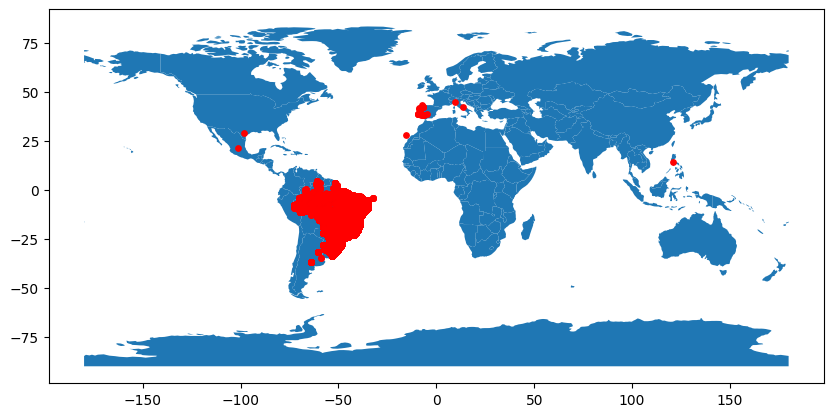

In [229]:
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame


geometry = [Point(xy) for xy in zip(geo_cust_sell['geolocation_lng'],
                                    geo_cust_sell['geolocation_lat'])]
gdf = GeoDataFrame(geo_cust_sell, geometry=geometry)

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15);

In [233]:
# Export the join into a CSV file in case you want to play around
geo_cust_sell.to_csv("cust_sell_geo.csv",sep = ',')
files.download('cust_sell_geo.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Step 5 - Join Orders Review Product

In [242]:
orders_review_df

orders_product_df


orders_rev_pro = pd.merge(orders_review_df,orders_product_df,on=['order_id'],how='outer',indicator=True)
print(orders_rev_pro['_merge'].value_counts())
print(orders_rev_pro['_merge'].count())
# Export the join into a CSV file in case you want to play around
orders_rev_pro.to_csv("orders_rev_pro.csv",sep = ',')
files.download('orders_rev_pro.csv')

print (100*pd.DataFrame({'Percentage at each sub set of a join, Left is ord rev, Rigth is prod and Both is match': orders_rev_pro.groupby(['_merge']).size() / len(orders_rev_pro)}))


both          102425
left_only        775
right_only         0
Name: _merge, dtype: int64
103200


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

            Percentage at each sub set of a join, Left is ord rev, Rigth is prod and Both is match
_merge                                                                                            
left_only                                            0.750969                                     
right_only                                           0.000000                                     
both                                                99.249031                                     


In [238]:
orders_review_df.dtypes


order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
review_id                                object
review_score                             object
review_comment_title                     object
review_comment_message                   object
review_creation_date             datetime64[ns]
review_answer_timestamp          datetime64[ns]
review                                     bool
dtype: object

In [239]:
orders_product_df.dtypes

product_id                        object
Sum_order_item_id                  int64
order_id                          object
seller_id                         object
shipping_limit_date               object
Sum_price                        float64
Sum_freight_value                float64
Right_product_id                  object
product_category_name             object
product_name_lenght              float64
product_description_lenght       float64
product_photos_qty               float64
product_weight_g                 float64
product_length_cm                float64
product_height_cm                float64
product_width_cm                 float64
product_error                     object
product_category_name_english     object
dtype: object

#Step 6 - Analyze operational Issues Hypothesis

#Step 7 - Review Classification Prediction Model

#Nice to have:



*   NLP for translations
*   External source for geo data
*   L
*   List item




